# DeepAtlas

This tutorial demonstrates the use of MONAI for simultaneous training of a registration and a segmentation network, following the approach of [DeepAtlas](https://biag.cs.unc.edu/publication/dblp-confmiccai-xu-n-19/).

Xu Z., Niethammer M. (2019) DeepAtlas: Joint Semi-supervised Learning of Image Registration and Segmentation. In: Shen D. et al. (eds) Medical Image Computing and Computer Assisted Intervention – MICCAI 2019. MICCAI 2019. Lecture Notes in Computer Science, vol 11765. Springer, Cham. https://doi.org/10.1007/978-3-030-32245-8_47

(TODO: briefly explain the "weak supervision" and "semi-supervision" concept in the context of deepatlas.
emphasize the common-ness of the use-case in which there is an abundance of images but limited segmentation data.)

**Contents:**
- [Environment](#Environment)
- [Imports](#Imports)
- [Data](#Data)
    - [Choose OASIS or synthetic data](#Choose-OASIS-or-synthetic-data)
    - [Resize option](#Resize-option)
    - [Create a list of data items](#Create-a-list-of-data-items)
    - [Datasets for segmentation network pretraining](#Datasets-for-segmentation-network-pretraining)
    - [Datasets for training both registration and segmentation networks](#Datasets-for-training-both-registration-and-segmentation-networks)
- [Segmentation network](#Segmentation-network)
- [Dice loss for segmentations](#Dice-loss-for-segmentations)
- [Registration network](#Registration-network)
- [Image similarity loss](#Image-similarity-loss)
- [Regularization loss for registration](#Regularization-loss-for-registration)
- [Segmentation network pre training](#Segmentation-network-pre-training)
- [Training both networks in alternation](#Training-both-networks-in-alternation)
    - [Prepare components to use in the training loop](#Prepare-components-to-use-in-the-training-loop)
    - [Training loop](#Training-loop)
- [Visualizing results](#Visualizing-results)

## Environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import numpy" || pip install -q numpy
!python -c "import torch" || pip install -q torch
!python -c "import itk" || pip install -q itk
%matplotlib inline

## Imports

In [2]:
import monai
import torch
import itk
import glob
import os.path
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import preview_image, preview_3D_vector_field, jacobian_determinant

monai.config.print_config()

# Set deterministic training for reproducibility
monai.utils.set_determinism(seed=2938649572)

MONAI version: 0.8.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-de

## Data

The data should consist of 3D images, some of which have associated segmentation labels.

### Choose OASIS or synthetic data

This tutorial was created with the OASIS-1 brain MRI dataset in mind.
It can also generate and use [synthetic data](https://docs.monai.io/en/latest/data.html#monai.data.synthetic.create_test_image_3d).

To run this with OASIS-1 data, you can download the [data here](https://www.oasis-brains.org/#data).
Make sure to select _OASIS-1_. Download as many of the "discs" as you like and extract their contents into a folder. Set `oasis_path` in the cell below to be the path of that folder.
If done correctly, `oasis_path` should contain subdirectories like `OAS1_0031_MR1`.

See the [fact sheet here](https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf)
for information on the OASIS-1 dataset.

---

Note that we already have a segmentaton for each image. In the case of OASIS-1 data, these segmentations were originally done by [an algorithm](https://pubmed.ncbi.nlm.nih.gov/11293691/).
In the case of synthetic data, true segmentations are generated for free by the process that creates the images.

The situation in which DeepAtlas is interesting is one where we have many unlabled images and just a handful of labels. We will simulate this situation by pretending that some of the segmentation labels don't exist.

---

Choose a data source by uncommenting only one of the two cells below.

In [4]:
# Uncomment the lines below to run the notebook with OASIS-1 data
# Set oasis_path to point to your extracted OASIS-1 data

num_segmentation_classes = 4 # background, CSF, white matter, gray matter

oasis_path = "/data/ebrahim-data/OASIS-1/" # TODO set this to a generic name
image_paths = glob.glob(os.path.join(oasis_path,'*/PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img'))
segmentation_paths = glob.glob(os.path.join(oasis_path,'*/FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img'))
path_to_id = lambda path : os.path.basename(path).strip('OAS1_')[:8]


# pretend that only a few segmentations are available
num_segs_to_select = 17
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]

In [5]:
# Uncomment the lines below to generate and use synthetic data

# num_segmentation_classes = 2 # background, not background

# data_synthetic_path = "./data_synthetic"
# if not os.path.exists(data_synthetic_path):
#     os.mkdir(data_synthetic_path)

# save_img = monai.transforms.SaveImage(output_dir = data_synthetic_path, output_postfix = "img", print_log=False)
# save_seg = monai.transforms.SaveImage(output_dir = data_synthetic_path, output_postfix = "seg", print_log=False)

# num_img_seg_pairs_to_generate = 50
# num_segs_to_select = 6

# for i in range(num_img_seg_pairs_to_generate):
#     img, seg = monai.data.synthetic.create_test_image_3d(
#         64, 64, 64, # image size
#         num_objs=1,
#         rad_max=30, rad_min=24,
#         noise_max=0.5, # try running with less noise
#         num_seg_classes=num_segmentation_classes-1, # background is not counted
#         channel_dim=0,
#         random_state=None
#     )
#     save_img(img)
#     if i < num_segs_to_select: # pretend that only a few segmentations are available
#         save_seg(seg)

# image_paths = glob.glob(os.path.join(data_synthetic_path,"*/*img.nii.gz"))
# segmentation_paths = glob.glob(os.path.join(data_synthetic_path,"*/*seg.nii.gz"))
# path_to_id = lambda path : os.path.basename(path).split('_')[0]

### Resize option

This is an option to keep memory usage under control.

For 3D images, the demands on video memory during UNet training can be intense.
You can reduce the batch sizes (possibly down to 1), but sometimes that is still not enough.
Applying a resize transform can allow you to still run the notebook if you
are otherwise running into memory issues.


In [6]:
# Set this to None for no resizing, or to an integer to resize all three spatial dimensions of loaded images
resize = 128

### Create a list of data items

Each data item in `data` below is a dictionary with an `'img'` key and maybe a `'seg'` key.
Having sometimes-missing keys is a good way to deal with partially available data--
it can be handled nicely by MONAI transforms
if we set `allow_missing_keys=True` in the transform parameters.
However, missing keys will pose an additional challenge when it comes to batching data together. These issues will come up later, when we set up transforms and when we set up dataloaders.

In [7]:
seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, image_paths)
data = []
for img_index,img_id in enumerate(img_ids):
    data_item = {'img' : image_paths[img_index]}
    if img_id in seg_ids:
        data_item['seg'] = segmentation_paths[seg_ids.index(img_id)]
    data.append(data_item)

In [8]:
# Uncomment the following to preview a random image
# data_item = random.choice(data)
# preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

### Datasets for segmentation network pretraining

In the DeepAtlas framework, one jointly or alternatively trains a registration network and a segmentation network. It is recommended that the segmentation network be pre-trained first, using whatever little segmentation is available.

We select the subset of `data` that has segmentation labels available, and then split that into a training set and a validation set. 

In [9]:
data_seg_available  =  list(filter(lambda d : 'seg' in d.keys() ,data))
data_seg_unavailable = list(filter(lambda d : 'seg' not in d.keys() ,data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8,2))
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

Next we set up the chain of transforms that will be used to load images and segmentations for the pre-training of the segmentation network.

<a id="augment"></a>
We'd like to keep this part of the tutorial simple, but this would be a good place to introduce data augmentation. Feel free to explore the random transforms that show up in the [documentation](https://docs.monai.io/en/stable/transforms.html) and go to town! Make sure any randomizable transforms appear _after_ the deterministic ones, for caching purposes. Make sure the interpolation mode for any transforms of segmentations is `"nearest"`.

In [10]:
transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
        monai.transforms.ToTensorD(keys=['img','seg']),
        monai.transforms.TransposeD(keys = ['img', 'seg'], indices = (2,1,0)),
        monai.transforms.AddChannelD(keys=['img','seg']),
        monai.transforms.ResizeD(
            keys = ['img', 'seg'],
            spatial_size=(resize, resize, resize),
            mode = ['trilinear', 'nearest'],
            align_corners=[False, None]
        ) if resize is not None else monai.transforms.Identity()
    ]
)



# Supress the many warnings related to depracation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
itk.ProcessObject.SetGlobalWarningDisplay(False)

# Uncomment the following lines to preview a random image with the transform above applied
# data_item = transform_seg_available(random.choice(data_seg_available))
# preview_image(data_item['img'][0])
# preview_image(data_item['seg'][0])

And now we define the datasets that use those transforms to load the data. We use `CacheDataset` to take advantage of MONAI's caching. 

In [11]:
dataset_seg_available_train = monai.data.CacheDataset(
    data = data_seg_available_train,
    transform = transform_seg_available,
    cache_num=8
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data = data_seg_available_valid,
    transform = transform_seg_available,
    cache_num=8
)

Loading dataset: 100%|██████████| 3/3 [00:00<00:00, 46.55it/s]


### Datasets for training both registration and segmentation networks

For the joint/alternative training of the registration and segmentation networks, we want to load _pairs_ of images, along with their segmentation labels when those are available. 

We reserve some images for validation of the registration network, then we create data lists for _pairs_ of images.

In [12]:
# During the joint/alternate training process, we will use reuse data_seg_available_valid
# for validating the segmentation network.
# So we should not let the registration or segmentation networks see these images in training.
data_without_seg_valid = data_seg_unavailable + data_seg_available_train # Note the order

# For validation of the registration network, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, # Note the order
    ratios=(2,8), # Note the order
    shuffle = False
)

def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j==i: continue
            d1 = data[i]
            d2 = data[j]
            pair = {
                'img1' : d1['img'],
                'img2' : d2['img']
            }
            if 'seg' in d1.keys():
                pair['seg1'] = d1['seg']
            if 'seg' in d2.keys():
                pair['seg2'] = d2['seg']
            data_pairs.append(pair)
    return data_pairs

data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

<a id="subdivide"></a>
At this point the data items in `data_pairs_train` and `data_pairs_valid` all have `img1` and `img2` keys, but only some of them have `seg1` or `seg2` keys. 

The variable presence of the `seg1` and `seg2` keys poses a problem for the collation of data into batches.
If we want a batch size greater than 1, then we need to address this.
Our approach is to subdivide the lists of data pairs based on the availability of `seg1` and `seg2`.
The naming convention will be as follows:

| key | segmentation availability |
| ----------- | ----------- |
| `00`      | no segs available |
| `01`   | seg2 available, but no seg1 |
| `10`   | seg1 available, but no seg2 |
| `11`   | both segs available |

In [13]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {'00':[], '01':[], '10':[], '11':[]}
    for d in data_pairs_list:
        if 'seg1' in d.keys() and 'seg2' in d.keys():
            out_dict['11'].append(d)
        elif 'seg1' in d.keys():
            out_dict['10'].append(d)
        elif 'seg2' in d.keys():
            out_dict['01'].append(d)
        else:
            out_dict['00'].append(d)
    return out_dict

data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

In [14]:
# print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = len(data_pairs_train_subdivided['01']) +\
    len(data_pairs_train_subdivided['10']) +\
    len(data_pairs_train_subdivided['11'])


print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 9450 pairs to train reg_net and seg_net together,
  and an additional 109230 to train reg_net alone.
We have 7310 pairs for reg_net validation.


Now we set up the chain of transforms that will be used for loading image pairs.

We will concatenate the "fixed" and "moving" images along the channel dimension.

Again this would be a good place to introduce data augmentation-- see the comment [above](#augment).

In [15]:
transform_pair = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img1','seg1', 'img2', 'seg2'], image_only=True,allow_missing_keys=True),
        monai.transforms.ToTensorD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.TransposeD(keys = ['img1','seg1', 'img2', 'seg2'], indices = (2,1,0), allow_missing_keys=True),
        monai.transforms.AddChannelD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2']),
        monai.transforms.ResizeD(
            keys = ['img12', 'seg1', 'seg2'],
            spatial_size=(resize, resize, resize),
            mode = ['trilinear', 'nearest', 'nearest'],
            allow_missing_keys=True,
            align_corners=[False, None, None]
        ) if resize is not None else monai.transforms.Identity()
    ]
)

And now we define the datasets that use the transforms to load the data. Again we use `CacheDataset` to take advantage of MONAI's caching.

In [16]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI datasets

dataset_pairs_train_subdivided = {
    seg_availability : monai.data.CacheDataset(
        data = data_list,
        transform = transform_pair,
        cache_num=16
    )
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability : monai.data.CacheDataset(
        data = data_list,
        transform = transform_pair,
        cache_num=16
    )
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset: 100%|██████████| 16/16 [00:00<00:00, 33.05it/s]


To help keep things straight, here is a guide to the naming convention we have used for the various objects that represent data:

| variable name component | suggested meaning |
| ----------- | ----------- |
| `data_`      | data items are dictionaries with keys mapping to filepaths |
| `dataset_`   | a MONAI dataset; getting an item loads images and applies transforms |
| `dataloader_`   | a MONAI dataloader; items from dataset are collated into batches |
| `_train_`   | data is meant for training |
| `_valid_`   | data is meant for validation |
| `_seg_available_`   | ground truth segmentations are available |
| `_seg_unavailable_`   | ground truth segmentations are not available |
| `_pairs_`   | data consists of ordered pairs of images and potentially segmentations |
| `_subdivided`   | a mapping from segmentation availability labels `00,10,01,11` to the suggested object |

(We have not defined any dataloaders yet, but we will soon enough)

## Segmentation network

We use a [MONAI UNet](https://docs.monai.io/en/stable/networks.html?highlight=unet#unet).

In [17]:
seg_net = monai.networks.nets.UNet(
    3, # spatial dims
    1, # input channels
    num_segmentation_classes, # output channels
    (8,16,16,32,32,64,64), # channel sequence
    (1,2,1,2,1,2), # convolutional strides
    dropout = 0.2,
    norm = 'batch'
)

A couple of differences compared to the architecture used in the paper:

- We downsample by using convolution with stride $>1$, rather than maxpooling.
- We use PReLU activation, rather than leaky ReLU


In [18]:
# Try out a forward pass

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item['img'].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg'])}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}") 

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 128, 128, 128])
Shape of seg_net output: torch.Size([1, 4, 128, 128, 128])


## Dice loss for segmentations

In [19]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True, # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True, # Note that our segmentation network is missing the softmax at the end
    reduction="mean"
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# This will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False,
    softmax=False,
    reduction="mean"
)

In [20]:
# Uncomment to try out the dice loss on the example.

# true_seg = data_item['seg'].unsqueeze(0)
# print(
#     dice_loss(
#         seg_net_example_output, # Prediction from seg_net, as logits
#         true_seg # Ground truth segmentation, as class labels rather than one-hot
#     ),
#     dice_loss2(
#         seg_net_example_output.softmax(dim=1), # Prediction from seg_net, as probabilities
#         monai.networks.one_hot(true_seg,
#                                num_classes=num_segmentation_classes) # Ground truth segmentation, one-hot encoded
#     ),
# )

## Registration network

In [21]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3, # spatial dims
    2, # input channels (one for fixed image and one for moving image)
    3, # output channels (to represent 3D displacement vector field)
    (16,32,32,32,32), # channel sequence
    (1,2,2,2), # convolutional strides
    dropout = 0.2,
    norm = "batch"
)

In [22]:
# Try out a forward pass

def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:],datasets[0])
    return random.choice(datasets_combined)

data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_output = reg_net(data_item['img12'].unsqueeze(0))
print(f"Shape of reg_net output: {reg_net_example_output.shape}") 

Shape of reg_net output: torch.Size([1, 3, 128, 128, 128])


We will interpret the output of `reg_net` as a displacement vector field.

However, this is just one way to use a UNet for registration.
The framework here is agnostic to the exact way in which the output of `reg_net` is interpreted,
as long is there is some differentiable way to combine the output of `reg_net` with an image and obtain
a warped image. One could, for example, interpret the output of `reg_net` as a velocity vector field, and then deform an image by flowing it along the vector field, as is done in fluid based registration.
The possibilities are endless.

To keep things simple, we choose a fairly direct interpretation: the output of `reg_net`
gives us the three components of a 3D displacement vector field.
A zero output from `reg_net`, for example, would result in the identity warping.
The 3-vector at each voxel tells us how many voxels to move in each direction,
and all together this defines a mapping from a subset of 3-space (the image domain) to 3-space.

In the MONAI documentation, you will see the term _dense displacement field (DDF)_ used to
refer to a 3-channel tensor interpreted in this way.

We now define `warp`, the object that applies a DDF to an image and yields a warped image.

In [23]:
# For warping segmentation labels or class predictions, we will want to use nearest neighbor interpolation
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="zeros")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="zeros")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item['img12'][[1],:,:,:].unsqueeze(0), # moving image
    reg_net_example_output # warping
)

# Uncomment to preview warped image from forward pass example above
# preview_image(example_warped_image[0,0].detach())

# Uncomment to preview displacement field forward pass example above
# preview_3D_vector_field(reg_net_example_output.detach()[0])

monai.networks.blocks.Warp: Using PyTorch native grid_sample.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


## Image similarity loss

To measure the similarity between target images and warped moving images, we use local normalized cross-correlation loss.

(The paper works with global NCC, but MONAI provides local NCC and it's easy to use.)

(Another slight difference: this loss function returns `-LNCC`, not `1-LNCC`)

In [24]:
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3,
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

In [25]:
# Uncomment to try out the image similarity loss on the example.

# lncc_loss(
#     example_warped_image, # registered image
#     data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
# )

## Regularization loss for registration

One of the greatest challenges in non-parameteric image registration is producing sufficiently smooth deformations. If we allow our model to propose deformations that vary chaotically over space,
it will happily do so in order to get images to match as closely as it can muster.

We use bending energy loss for regularization.

This type of image registration is referred to as _elastic_.

In [26]:
bending_loss = monai.losses.BendingEnergyLoss()

# Uncomment to try out the bending energy loss on the example
# bending_loss(reg_net_example_output)

## Segmentation network pre-training

We now pre-train the segmentation network, using whatever little segmentation data is available.

In [27]:
# Set up dataloaders

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train,
    batch_size=8,
    num_workers=4,
    shuffle=True
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid,
    batch_size=16,
    num_workers=4,
    shuffle=False
)

Epoch 1/60:
	training loss: 0.8430949747562408
	tvalidation loss: 0.8196889162063599


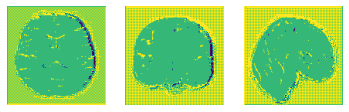

Epoch 2/60:
	training loss: 0.7798373997211456
Epoch 3/60:
	training loss: 0.7323565483093262
Epoch 4/60:
	training loss: 0.6885644495487213
Epoch 5/60:
	training loss: 0.6460653245449066
Epoch 6/60:
	training loss: 0.6043907701969147
	tvalidation loss: 0.6905608177185059


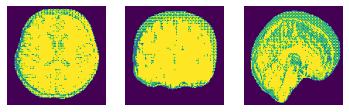

Epoch 7/60:
	training loss: 0.5615990459918976
Epoch 8/60:
	training loss: 0.519078254699707
Epoch 9/60:
	training loss: 0.4770570993423462
Epoch 10/60:
	training loss: 0.4324944466352463
Epoch 11/60:
	training loss: 0.38816946744918823
	tvalidation loss: 0.5859593152999878


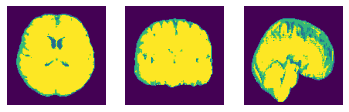

Epoch 12/60:
	training loss: 0.3494255840778351
Epoch 13/60:
	training loss: 0.3179340362548828
Epoch 14/60:
	training loss: 0.29340530931949615
Epoch 15/60:
	training loss: 0.27204206585884094
Epoch 16/60:
	training loss: 0.2522856742143631
	tvalidation loss: 0.4472995698451996


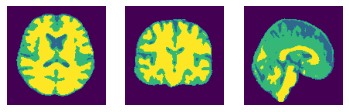

Epoch 17/60:
	training loss: 0.23774440586566925
Epoch 18/60:
	training loss: 0.2258094772696495
Epoch 19/60:
	training loss: 0.21617234498262405
Epoch 20/60:
	training loss: 0.20772619545459747
Epoch 21/60:
	training loss: 0.20070697367191315
	tvalidation loss: 0.29624173045158386


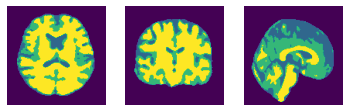

Epoch 22/60:
	training loss: 0.19402053952217102
Epoch 23/60:
	training loss: 0.18952981382608414
Epoch 24/60:
	training loss: 0.1851373314857483
Epoch 25/60:
	training loss: 0.18118491023778915
Epoch 26/60:
	training loss: 0.17756016552448273
	tvalidation loss: 0.18870139122009277


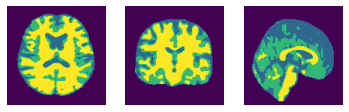

Epoch 27/60:
	training loss: 0.17456237226724625
Epoch 28/60:
	training loss: 0.17140211164951324
Epoch 29/60:
	training loss: 0.16843178123235703
Epoch 30/60:
	training loss: 0.16619443148374557
Epoch 31/60:
	training loss: 0.16444091498851776
	tvalidation loss: 0.15301549434661865


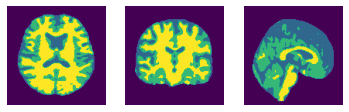

Epoch 32/60:
	training loss: 0.162608340382576
Epoch 33/60:
	training loss: 0.15973366051912308
Epoch 34/60:
	training loss: 0.1585453525185585
Epoch 35/60:
	training loss: 0.157473124563694
Epoch 36/60:
	training loss: 0.15575715154409409
	tvalidation loss: 0.13919657468795776


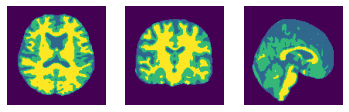

Epoch 37/60:
	training loss: 0.15350916236639023
Epoch 38/60:
	training loss: 0.1523788496851921
Epoch 39/60:
	training loss: 0.15175878256559372
Epoch 40/60:
	training loss: 0.1490669697523117
Epoch 41/60:
	training loss: 0.14762789011001587
	tvalidation loss: 0.1406058371067047


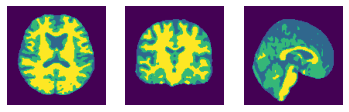

Epoch 42/60:
	training loss: 0.1468363031744957
Epoch 43/60:
	training loss: 0.1459280550479889
Epoch 44/60:
	training loss: 0.14375513792037964
Epoch 45/60:
	training loss: 0.1421336680650711
Epoch 46/60:
	training loss: 0.14497727155685425
	tvalidation loss: 0.14785389602184296


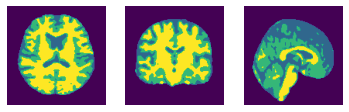

Epoch 47/60:
	training loss: 0.14000996202230453
Epoch 48/60:
	training loss: 0.1400141790509224
Epoch 49/60:
	training loss: 0.13804469257593155
Epoch 50/60:
	training loss: 0.1388457641005516
Epoch 51/60:
	training loss: 0.13732385635375977
	tvalidation loss: 0.12658634781837463


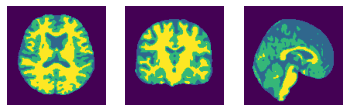

Epoch 52/60:
	training loss: 0.13927322626113892
Epoch 53/60:
	training loss: 0.13557758927345276
Epoch 54/60:
	training loss: 0.13560494780540466
Epoch 55/60:
	training loss: 0.13439647108316422
Epoch 56/60:
	training loss: 0.1337369978427887
	tvalidation loss: 0.11572077125310898


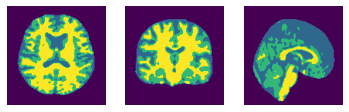

Epoch 57/60:
	training loss: 0.13283221423625946
Epoch 58/60:
	training loss: 0.1312548890709877
Epoch 59/60:
	training loss: 0.13095563650131226
Epoch 60/60:
	training loss: 0.13045307993888855


In [28]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

device = torch.device("cuda:0")
seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 60
training_losses = []
validation_losses = []
validation_every = 5

for epoch_number in range(max_epochs):
    
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    
    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch['img'].to(device)
        true_segs = batch['seg'].to(device)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch['img'].to(device)
                true_segs = batch['seg'].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])
    
        # Uncomment to preview a particular predicted segmentation during training
        preview_image(torch.argmax(torch.softmax(seg_net(dataset_seg_available_valid[0]['img'].unsqueeze(0).cuda()),dim=1),dim=1, keepdim=True)[0,0].cpu(), figsize=(6,6))
    

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

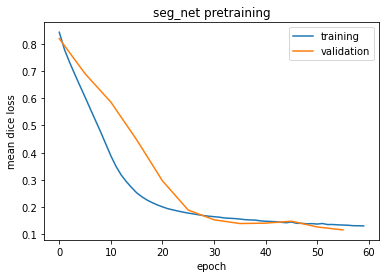

In [29]:
# Plot the training and validation losses

def plot_against_epoch_numbers(epoch_and_value_pairs, **kwargs):
    array = np.array(epoch_and_value_pairs)
    plt.plot(array[:,0], array[:,1], **kwargs)

plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean dice loss')
plt.title('seg_net pretraining')
plt.savefig('seg_net_pretrained_losses.png')
plt.show()

In [30]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(),'seg_net_pretrained.pth')

In [31]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

Original image from validation set:


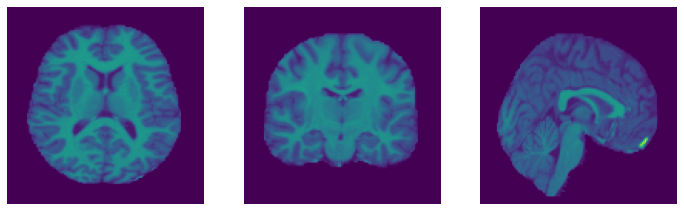

Ground truth segmentation:


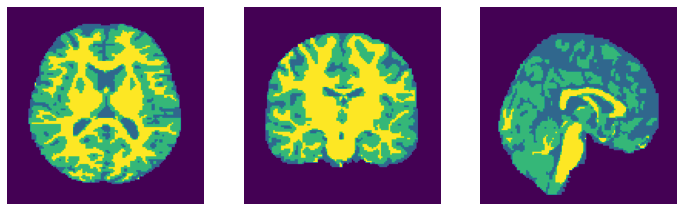

Our predicted segmentation:


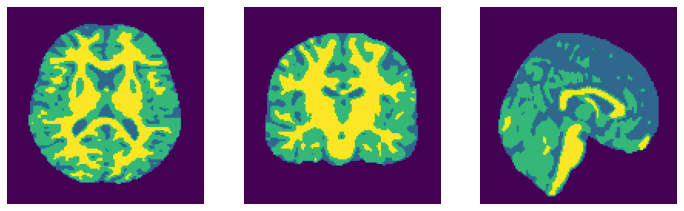

In [32]:
# Run this cell to try out the pretrained seg net on a random validation image

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted,dim=1),dim=1, keepdim=True)[0,0])

del test_seg_predicted
torch.cuda.empty_cache()

## Training both networks in alternation

We can train `reg_net` and `seg_net` *jointly*, or *in alternation*.
We choose to do the latter because it's more memory-conservative.
In the case of brain MRI data, the forward pass for even a single batch can be very demanding on memory.

Note that this training is not adversarial.
Neither of the two networks is directly penalized for the improved performance of the other network.
Each network merely provides a noisy "ground truth" for the other to train from.
We do not expect the sort of instability that often plagues adversarial training and that makes alternative training less viable. 

### Prepare components to use in the training loop

While training one network, we don't want to compute gradients for the other. The following function streamlines this.

In [33]:
def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False
    
    for param in network_to_train.parameters():
        param.requires_grad = True
        
    network_to_not_train.eval()
    network_to_train.train()

Now, following the paper, we define regularization loss, similarity loss, and anatomy loss.

In [34]:
# Functions to compute the ingredients of the final loss computation for reg_net

regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """ Accepts a batch of displacement fields, shape (B,3,L,W,H),
        and a batch of image pairs, shape (B,2,L,W,H). """
    warped_img2 = warp(image_pair[:,[1],:,:,:], displacement_field)
    return lncc_loss(
        warped_img2, # prediction
        image_pair[:,[0],:,:,:] # target
    )

def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1 = None, gt_seg2 = None):
    """ 
    Accepts a batch of displacement fields, shape (B,3,L,W,H),
    and a batch of image pairs, shape (B,2,L,W,H).
    seg_net is the model used to segment an image,
      mapping (B,1,L,W,H) to (B,C,L,W,H) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,L,W,H)
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(
            gt_seg1 , num_segmentation_classes
        )
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:,[0],:,:,:]).softmax(dim=1) 

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(
            gt_seg2 , num_segmentation_classes
        )
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:,[1],:,:,:]).softmax(dim=1)

    # seg1 and seg2 should now be in the form of one-hot class probabilities

    return dice_loss2(
        warp_nearest(seg2, displacement_field), # warp of moving image segmentation
        seg1 # target image segmentation
    )

In [35]:
# Function for forward pass of reg_net, to avoid duplicating code between training and validation

def reg_losses(batch):
    img12 = batch['img12'].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch['seg1'].to(device) if 'seg1' in batch.keys() else None
    gt_seg2 = batch['seg2'].to(device) if 'seg2' in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana

Recall from [above](#subdivide) that we have a dataset for each "segmentation availability label" from `00,10,01,11`. The purpose of this subdivision is to allow data to be collated into tensors with a batch dimension.

Then we must have a four dataloaders, one for each segmentation availability label.
Four for `reg_net` training, and four for `reg_net` validation.

In [36]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability : monai.data.DataLoader(
        dataset,
        batch_size=2,
        num_workers=4,
        shuffle=True
    )
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability : monai.data.DataLoader(
        dataset,
        batch_size=4,
        num_workers=4,
        shuffle=True # Shuffle validation data because we will only take a sample for validation each time
    )
        if len(dataset) > 0 else [] # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

Having four dataloaders can make the training loop look unnecessarily complicated.

To keep the training loop simple, we will create generators that can run all four dataloaders
and sample them.

In [37]:
seg_availabilities = ['00', '01', '10', '11']
def create_batch_generator(dataloader_subdivided, weights = None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.
    
    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets
                  
    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and 
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s:iter(d) for s,d in dataloader_subdivided.items()}
    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration: # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] =\
                    iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])
    return batch_generator

In [38]:
batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)


# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0]+[len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with weights {seg_train_sampling_weights}""")
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

When training seg_net alone, segmentation availabilities ['00', '01', '10', '11']
will be sampled with weights [0, 2317, 2317, 91]


### Training loop

Finally, we train `reg_net` and `seg_net` in alternation.

The word "epoch" is being misused in this cell.
When training `reg_net`, we don't run through _all_ the data in each iteration of this loop.
There are a lot of data pairs, and running through all of them is time consuming.
"Epoch" here is just a convenient name for 
> _one iteration of the loop in which we train `reg_net` on
a bunch of image pairs, train `seg_net` on a bunch of image pairs, possibly compute some performance metrics, and log some info_

It's a misnomer.

In [39]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

seg_net.to(device)
reg_net.to(device)


learning_rate_reg = 5e-4
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# Weights of various registration losses, relative to the image similarity loss
lambda_r  = 0.25 # regularization loss weight
lambda_a  = 2.0 # anatomy loss weight
lambda_sp = 3.0 # supervised segmentation loss weight


max_epochs = 40
reg_phase_training_batches_per_epoch = 40
seg_phase_training_batches_per_epoch = 10
reg_phase_num_validation_batches_to_use = 40
validation_every = 5

training_losses_reg = []
validation_losses_reg = []
training_losses_seg = []
validation_losses_seg = []



for epoch_number in range(max_epochs):
    
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    
    # ------------------------------------------------
    #         reg_net training phase
    # ------------------------------------------------
    
    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)
    
    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())
            
        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])
    
    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()
    
    # ------------------------------------------------
    #         seg_net training phase
    # ------------------------------------------------
    
    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)
    
    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()
        
        img12 = batch['img12'].to(device)
        
        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:,[0],:,:,:]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:,[1],:,:,:]).softmax(dim=1)
        
        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training 
        
        if 'seg1' in batch.keys() and 'seg2' in batch.keys():
            seg1 = monai.networks.one_hot(batch['seg1'].to(device) , num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch['seg2'].to(device) , num_segmentation_classes)
            loss_metric = dice_loss2( seg2_predicted , seg2 )
            loss_supervised = dice_loss2( seg1_predicted , seg1 ) + loss_metric
            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.
            
        elif 'seg1' in batch.keys(): # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch['seg1'].to(device) , num_segmentation_classes)
            loss_metric = dice_loss2( seg1_predicted , seg1 )
            loss_supervised = loss_metric
            seg2 = seg2_predicted # Use this in anatomy loss
        
        else: # seg2 available, but no seg1
            assert('seg2' in batch.keys())
            seg2 = monai.networks.one_hot(batch['seg2'].to(device) , num_segmentation_classes)
            loss_metric = dice_loss2( seg2_predicted , seg2 )
            loss_supervised = loss_metric
            seg1 = seg1_predicted # Use this in anatomy loss
            
        # seg1 and seg2 should now be in the form of one-hot class probabilities
        
        loss_anatomy = dice_loss2( warp_nearest(seg2, displacement_fields), seg1 )\
            if 'seg1' in batch.keys() or 'seg2' in batch.keys()\
            else 0. # It wouldn't really be 0, but it would not contribute to training seg_net
        # (If you want to refactor this code for *joint* training of reg_net and seg_net,
        #  then remove this conditional and compute the anatomy loss in all cases)
            
        
        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()

        losses.append(loss_metric.item())
    
    training_loss = np.mean(losses)
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])
    
    if epoch_number%validation_every == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch['img'].to(device)
                true_segs = batch['seg'].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())
        
        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])
    
    # Free up memory
    del loss, seg1, seg2, displacement_fields, img12, loss_supervised, loss_anatomy, loss_metric,\
        seg1_predicted, seg2_predicted
    torch.cuda.empty_cache()


Epoch 1/40:
	reg training loss: 0.11956159994006157
	reg validation loss: -0.11785574406385421
	seg training loss: 0.14203666299581527
	seg validation loss: 0.14035727083683014
Epoch 2/40:
	reg training loss: -0.06725481003522873
	seg training loss: 0.13980862945318223
Epoch 3/40:
	reg training loss: -0.11586865186691284
	seg training loss: 0.12591168656945229
Epoch 4/40:
	reg training loss: -0.15487876534461975
	seg training loss: 0.12911437824368477
Epoch 5/40:
	reg training loss: -0.18623243421316146
	seg training loss: 0.12450131326913834
Epoch 6/40:
	reg training loss: -0.1882683351635933
	reg validation loss: -0.2062782034277916
	seg training loss: 0.12621084824204445
	seg validation loss: 0.14760544896125793
Epoch 7/40:
	reg training loss: -0.19800459146499633
	seg training loss: 0.1236075334250927
Epoch 8/40:
	reg training loss: -0.20188245177268982
	seg training loss: 0.12110906317830086
Epoch 9/40:
	reg training loss: -0.23005380034446715
	seg training loss: 0.118037902563810

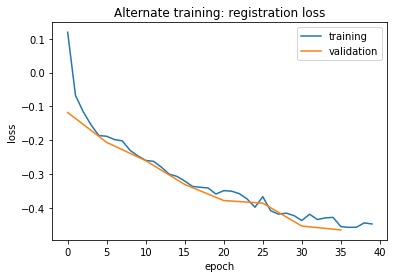

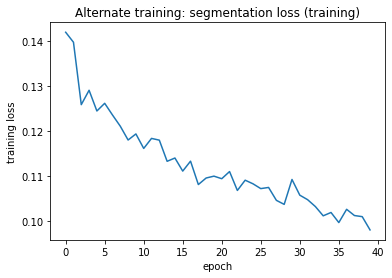

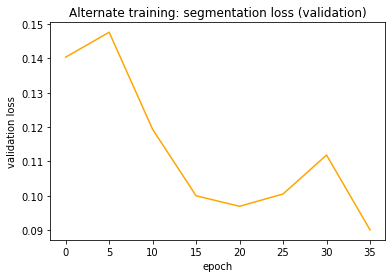

In [40]:
# Plot the training and validation losses

plot_against_epoch_numbers(training_losses_reg, label="training")
plot_against_epoch_numbers(validation_losses_reg, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Alternate training: registration loss')
plt.savefig('reg_net_losses.png')
plt.show()

plot_against_epoch_numbers(training_losses_seg, label="training")
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Alternate training: segmentation loss (training)')
plt.savefig('seg_net_training_losses.png')
plt.show()

plot_against_epoch_numbers(validation_losses_seg, label="validation", color='orange')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Alternate training: segmentation loss (validation)')
plt.savefig('seg_net_validation_losses.png')
plt.show()

In [41]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(),'seg_net.pth')
torch.save(reg_net.state_dict(),'reg_net.pth')

In [42]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net.pth'))
# reg_net.load_state_dict(torch.load('reg_net.pth'))

## Visualizing results

In [1]:
# Run this cell to try out reg net on a random validation pair

reg_net.to(device)
reg_net.eval()

data_item = take_random_from_subdivided_dataset(dataset_pairs_valid_subdivided)
img12 = data_item['img12'].unsqueeze(0).to(device)

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(
    img12[:,[1],:,:,:], # moving image
    reg_net_example_output # warping
)

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0,1,:,:,:].cpu(), normalize_by="slice", cmap='gray')
print("target image:")
preview_image(img12[0,0,:,:,:].cpu(), normalize_by="slice", cmap='gray')
print("warped moving image:")
preview_image(example_warped_image[0,0].cpu(), normalize_by="slice", cmap='gray')
print("deformation field:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by='slice', threshold=0)
loss = lncc_loss(example_warped_image,img12[:,[0],:,:,:]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

NameError: name 'reg_net' is not defined

That last image, the Jacobian determinant field, is a useful way to visualize the effect of the deformation generated by `reg_net`. This is a scalar field that tells us, at each voxel, the scale factor by which volumes are scaled near that voxel. Where it's negative, it's telling us that the deformation map locally reverses orientation at that location. We refer to voxels where the Jacobian determinant is negative as "folds." Folds are shown in red in the preview above.

<!-- This isn't perfect, of course. We don't really have a map from a subset of $\mathbb{R}^3$ to $\mathbb{R}^3$, but a discretely sampled version of one. We are not taking derivatives-- we are taking discrete differences. So some folds here and there might not really indicate anything bad... hmm not sure about this... commenting out for now -->

The number of folds that occur while registering a pair of images is a nice way to think about how "bad" the deformation is.

original image from validation set:


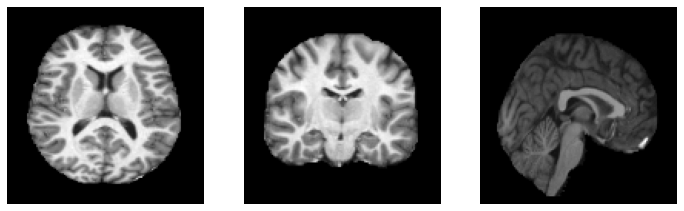

ground truth segmentation:


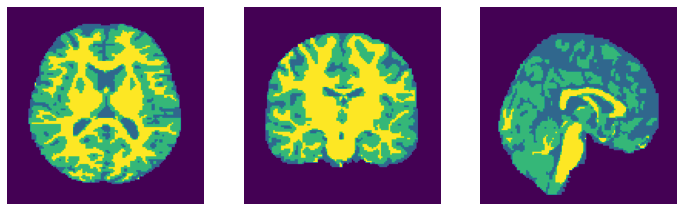

our predicted segmentation:


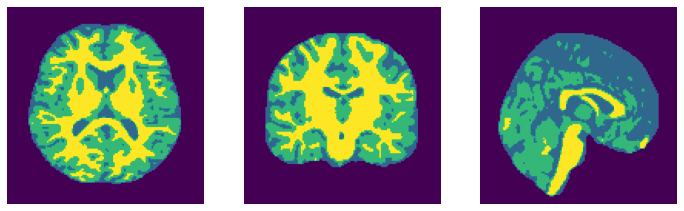

dice loss: 0.09908062219619751


In [44]:
# Uncomment to try out seg net on one of the validation images

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("original image from validation set:")
preview_image(test_input[0], normalize_by="slice", cmap='gray')
print("ground truth segmentation:")
preview_image(test_seg_true[0])
print("our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted,dim=1),dim=1, keepdim=True)[0,0])
print(f"dice loss: {loss}")

del test_seg_predicted
torch.cuda.empty_cache()

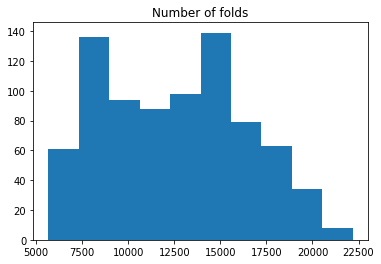

Mean fold count: 12561.28125


In [45]:
# Here we evaluate the regularity of reg_net
# by sampling some image pairs from the validation set
# and counting folds

num_batches = 200 # sample this many batches

fold_counts = []
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches):
        img12 = batch['img12'].to(device)
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field.cpu())
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
        
del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig('folds_histogram.png')
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)}")